## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

In [2]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [3]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    """
    주어진 데이터프레임을 특정 열들로 그룹화하여 각 그룹의 '임신_성공_여부' 비율과 갯수를 요약하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_columns (list): 그룹화할 열 이름들의 리스트
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '임신 성공' 비율과 갯수 계산
        success_count = group['임신_성공_여부'].value_counts().get(1, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신_성공_여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

def plot_ratio(df, group_by_column, target_column='임신_성공_여부', success_value=1):
    """
    주어진 데이터프레임을 특정 열로 그룹화하여 각 그룹의 타겟 변수의 성공 비율을 시각화하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_column (str): 그룹화할 열 이름
    target_column (str): 타겟 변수 이름
    success_value (int): 타겟 변수의 성공을 나타내는 값
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '성공' 비율과 갯수 계산
        success_count = group[target_column].value_counts().get(success_value, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{success_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (success_count, total) in enumerate(zip(results_df[f"'{success_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{success_count} ({total})', ha='center', va='bottom', fontsize=8)
    
    # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{success_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{success_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, column_name, target_column='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열과 타겟 변수 간의 관계를 박스 플롯으로 시각화하는 함수.

    Parameters:
    data (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_column (str): 타겟 변수 이름
    """

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{column_name} vs {target_column}')
    plt.xlabel(column_name)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

### Data Load

In [4]:
# 데이터 로드
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 변수명에서 공백을 밑줄로 대체
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

# 변경된 변수명 확인
print(train.columns)

Index(['ID', '시술_시기_코드', '시술_당시_나이', '임신_시도_또는_마지막_임신_경과_연수', '시술_유형',
       '특정_시술_유형', '배란_자극_여부', '배란_유도_유형', '단일_배아_이식_여부', '착상_전_유전_검사_사용_여부',
       '착상_전_유전_진단_사용_여부', '남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인',
       '여성_부_불임_원인', '부부_주_불임_원인', '부부_부_불임_원인', '불명확_불임_원인', '불임_원인_-_난관_질환',
       '불임_원인_-_남성_요인', '불임_원인_-_배란_장애', '불임_원인_-_여성_요인', '불임_원인_-_자궁경부_문제',
       '불임_원인_-_자궁내막증', '불임_원인_-_정자_농도', '불임_원인_-_정자_면역학적_요인',
       '불임_원인_-_정자_운동성', '불임_원인_-_정자_형태', '배아_생성_주요_이유', '총_시술_횟수',
       '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수',
       'DI_임신_횟수', '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수', '총_생성_배아_수',
       '미세주입된_난자_수', '미세주입에서_생성된_배아_수', '이식된_배아_수', '미세주입_배아_이식_수', '저장된_배아_수',
       '미세주입_후_저장된_배아_수', '해동된_배아_수', '해동_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수',
       '혼합된_난자_수', '파트너_정자와_혼합된_난자_수', '기증자_정자와_혼합된_난자_수', '난자_출처', '정자_출처',
       '난자_기증자_나이', '정자_기증자_나이', '동결_배아_사용_여부', '신선_배아_사용_여부', '기증_배아_사용_여부',
       '대리모_여부', 'PGD_시술_여부', 'PGS_시술_여부

In [5]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256351 non-null  object 
 1   시술_시기_코드               256351 non-null  object 
 2   시술_당시_나이               256351 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 4   시술_유형                  256351 non-null  object 
 5   특정_시술_유형               256349 non-null  object 
 6   배란_자극_여부               256351 non-null  int64  
 7   배란_유도_유형               256351 non-null  object 
 8   단일_배아_이식_여부            250060 non-null  float64
 9   착상_전_유전_검사_사용_여부       2718 non-null    float64
 10  착상_전_유전_진단_사용_여부       250060 non-null  float64
 11  남성_주_불임_원인             256351 non-null  int64  
 12  남성_부_불임_원인             256351 non-null  int64  
 13  여성_주_불임_원인             256351 non-null  int64  
 14  여성_부_불임_원인             256351 non-nu

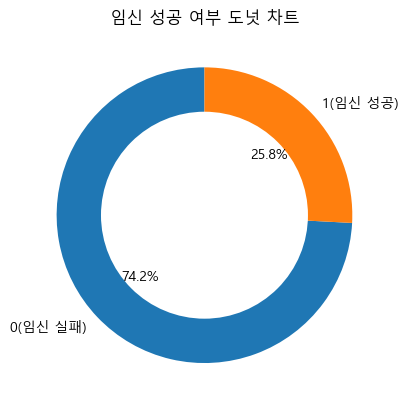

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

## EDA

In [7]:
# '시술_시기_코드' 변수의 값이 'TRYBLT'에 해당 안하는 데이터 추출
IVF_train = train[train['시술_시기_코드'] == 'TRYBLT'] 
IVF_test = test[test['시술_시기_코드'] == 'TRYBLT']

# 모든 값이 결측값인 변수를 제거
IVF_train = IVF_train.dropna(axis=1, how='all')
IVF_test = IVF_test.dropna(axis=1, how='all')

train = IVF_train
test = IVF_test

### 1. 시술_시기_코드

난임 시술을 받은 시기를 기준으로 코드 부여

In [8]:
value_counts_ratio(train, '시술_시기_코드')


시술_시기_코드별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
TRYBLT    0.730913  0.269087  26834  9879  36713


In [9]:
# '시술_시기_코드' 변수 제거
train = train.drop(columns=['시술_시기_코드'])
test = test.drop(columns=['시술_시기_코드'])

### 2. 시술 당시 나이

환자의 시술 당시 나이(연령대)

In [10]:
value_counts_ratio(train, '시술_당시_나이')


시술_당시_나이별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
만18-34세   0.666145  0.333855  9791.0  4907.0  14698
만35-37세   0.705080  0.294920  5843.0  2444.0   8287
만38-39세   0.772893  0.227107  4237.0  1245.0   5482
만40-42세   0.840951  0.159049  4526.0   856.0   5382
만43-44세   0.864088  0.135912  1564.0   246.0   1810
만45-50세   0.818090  0.181910   814.0   181.0    995
알 수 없음    1.000000  0.000000    59.0     0.0     59


In [11]:
test['시술_당시_나이'].value_counts()

만18-34세    5190
만35-37세    2816
만40-42세    1938
만38-39세    1935
만43-44세     652
만45-50세     371
알 수 없음       27
Name: 시술_당시_나이, dtype: int64

### 3. 임신 시도 또는 마지막 임신 경과 일수

환자가 처음 임신을 시도한 시점 또는 마지막 임신 이후 현재까지의 경과 연수 (년 단위)

In [12]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0.0       0.500000  0.500000   1.0   1.0      2
2.0       1.000000  0.000000   1.0   0.0      1
3.0       0.000000  1.000000   0.0   1.0      1
4.0       0.500000  0.500000   1.0   1.0      2
5.0       0.500000  0.500000   1.0   1.0      2
6.0       0.750000  0.250000   3.0   1.0      4
7.0       0.714286  0.285714   5.0   2.0      7
8.0       0.823529  0.176471  14.0   3.0     17
9.0       0.762712  0.237288  45.0  14.0     59
10.0      0.791667  0.208333  38.0  10.0     48
11.0      0.866667  0.133333  52.0   8.0     60
12.0      0.770833  0.229167  37.0  11.0     48
13.0      0.846154  0.153846  33.0   6.0     39
14.0      0.813953  0.186047  35.0   8.0     43
15.0      0.766667  0.233333  23.0   7.0     30
16.0      1.000000  0.000000  11.0   0.0     11
17.0      0.750000  0.250000   6.0   2.0      8
18.0      0.833333  0.166667   5.0   1.0      

In [13]:
# 3년 단위로 범주화
bins = list(range(0, 24, 3))  # 0부터 20까지 3년 단위로 구간 생성
labels = [f'{i}-{i+2}년' for i in range(0, 21, 3)]  # 범주 레이블 생성

train['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(train['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)
test['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(test['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)

# 결측값을 'unknown'으로 채우기 위해 범주에 'unknown' 추가
train['임신_시도_또는_마지막_임신_경과_연수'] = train['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])
test['임신_시도_또는_마지막_임신_경과_연수'] = test['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])

train['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)
test['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)

In [14]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0-2년      0.666667  0.333333      2     1      3
3-5년      0.400000  0.600000      2     3      5
6-8년      0.785714  0.214286     22     6     28
9-11년     0.808383  0.191617    135    32    167
12-14년    0.807692  0.192308    105    25    130
15-17년    0.816327  0.183673     40     9     49
18-20년    0.800000  0.200000     16     4     20
unknown   0.730137  0.269863  26512  9799  36311


### 4. 시술_유형

IVF 또는 DI 시술 여부

In [15]:
value_counts_ratio(train, '시술_유형')


시술_유형별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
DI        0.865811  0.134189    742   115    857
IVF       0.727689  0.272311  26092  9764  35856


In [16]:
test['시술_유형'].value_counts()

IVF    12626
DI       303
Name: 시술_유형, dtype: int64

### 5. 특정_시술_유형

IVF – 체외 수정 (시험관 아기 시술)  
ICSI – 세포질 내 정자 주입  
IUI – 인공 수정 (자궁 내 주입)  
ICI – 자궁경부 인공 수정  
GIFT – 생식세포 나팔관 이식  
FER – 냉동 배아 이식  
Generic DI – 기증 정자 주입  
IVI – 질 내 인공 수정   
BLASTOCYST – 배반포 단계에 이식  
AH – 배아를 hatching 시켜주는 과정  
Unknown – 시술 유형 정보가 제공되지 않았거나 알 수 없음  

(*) 특수 기호의 의미  
"/" – 복합적인 시술 방법을 의미 (예: ICSI / BLASTOCYST)  
":" – 동일 시술 내 세부 조합을 의미 (예: ICSI:IVF)  

In [17]:
summarize_group(train, ['특정_시술_유형'])

Grouped by: 특정_시술_유형

                 group  '임신_성공_여부' count     ratio  Total
0           Generic DI                 1  0.166667      6
1                  ICI                 1  0.333333      3
2                 ICSI              5082  0.285201  17819
3            ICSI / AH                 4  0.222222     18
4    ICSI / AH:Unknown                 1  0.500000      2
5   ICSI / BLASTOCYST                 12  0.461538     26
6            ICSI:ICSI                 5  0.015106    331
7             ICSI:IVF                27  0.195652    138
8         ICSI:Unknown                 3  0.096774     31
9                  IUI               113  0.133570    846
10                 IVF              3561  0.269548  13211
11            IVF / AH                 0  0.000000      6
12  IVF / AH:ICSI / AH                 0  0.000000      1
13    IVF / BLASTOCYST                 6  0.193548     31
14            IVF:ICSI                19  0.292308     65
15             IVF:IVF                 3  0.017341

In [18]:
test['특정_시술_유형'].value_counts()

ICSI                  6399
IVF                   4630
Unknown               1332
IUI                    300
ICSI:ICSI              107
ICSI:IVF                51
IVF:IVF                 44
IVF:ICSI                19
IVF / BLASTOCYST        10
ICSI:Unknown             9
ICSI / BLASTOCYST        9
ICSI / AH                9
IVF:Unknown              5
Generic DI               3
IVF / AH                 2
Name: 특정_시술_유형, dtype: int64

In [19]:
# '특정_시술_유형' 변수의 값이 'FER' 또는 'GIFT'인 행 제거
train = train.loc[~train['특정_시술_유형'].isin(['FER', 'GIFT'])]
# test = test.loc[~test['특정_시술_유형'].isin(['FER', 'GIFT'])]

In [20]:
# 시술 유형 변환 함수
def transform_treatment(treatment):
    if isinstance(treatment, str):  # treatment가 문자열인지 확인
        if treatment.startswith("ICSI"):
            if "AH" in treatment:
                return "ICSI / AH"
            elif "BLASTOCYST" in treatment:
                return "ICSI / BLASTOCYST"
            return "ICSI"
        elif treatment.startswith("IVF"):
            if "AH" in treatment:
                return "IVF / AH"
            elif "BLASTOCYST" in treatment:
                return "IVF / BLASTOCYST"
            return "IVF"
        elif treatment == "IUI:ICI":
            return "IUI"
    return treatment  # 기타 시술은 그대로 반환

# 변환된 열 추가
train['변환된_특정_시술_유형'] = train['특정_시술_유형'].apply(transform_treatment)
test['변환된_특정_시술_유형'] = test['특정_시술_유형'].apply(transform_treatment)

In [21]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                          0         1        0       1  Total
variable                                                     
Generic DI         0.833333  0.166667      5.0     1.0      6
ICI                0.666667  0.333333      2.0     1.0      3
ICSI               0.720673  0.279327  13202.0  5117.0  18319
ICSI / AH          0.750000  0.250000     15.0     5.0     20
ICSI / BLASTOCYST  0.538462  0.461538     14.0    12.0     26
IUI                0.866430  0.133570    733.0   113.0    846
IVF                0.733710  0.266290   9875.0  3584.0  13459
IVF / AH           1.000000  0.000000      7.0     0.0      7
IVF / BLASTOCYST   0.806452  0.193548     25.0     6.0     31
IVI                1.000000  0.000000      2.0     0.0      2
Unknown            0.739609  0.260391   2954.0  1040.0   3994


In [22]:
test['변환된_특정_시술_유형'].value_counts()

ICSI                 6566
IVF                  4698
Unknown              1332
IUI                   300
IVF / BLASTOCYST       10
ICSI / BLASTOCYST       9
ICSI / AH               9
Generic DI              3
IVF / AH                2
Name: 변환된_특정_시술_유형, dtype: int64

In [23]:
# 더미 변수 생성 함수 정의
def create_dummy(x, keyword):
    if isinstance(x, str) and keyword in x:
        return 1
    else:
        return 0

# 더미 변수 생성
train['특정_시술_유형_ICSI_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
train['특정_시술_유형_IVF_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
train['특정_시술_유형_AH_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
train['특정_시술_유형_BLASTOCYST_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

test['특정_시술_유형_ICSI_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
test['특정_시술_유형_IVF_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
test['특정_시술_유형_AH_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
test['특정_시술_유형_BLASTOCYST_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

In [24]:
summarize_group(train, ['특정_시술_유형',
                        '특정_시술_유형_ICSI_더미',
                          '특정_시술_유형_IVF_더미',
                            '특정_시술_유형_AH_더미',
                              '특정_시술_유형_BLASTOCYST_더미'])

Grouped by: 특정_시술_유형, 특정_시술_유형_ICSI_더미, 특정_시술_유형_IVF_더미, 특정_시술_유형_AH_더미, 특정_시술_유형_BLASTOCYST_더미

                               group  '임신_성공_여부' count     ratio  Total
0           (Generic DI, 0, 0, 0, 0)                 1  0.166667      6
1                  (ICI, 0, 0, 0, 0)                 1  0.333333      3
2                 (ICSI, 1, 0, 0, 0)              5082  0.285201  17819
3            (ICSI / AH, 1, 0, 1, 0)                 4  0.222222     18
4    (ICSI / AH:Unknown, 1, 0, 1, 0)                 1  0.500000      2
5   (ICSI / BLASTOCYST , 1, 0, 0, 1)                12  0.461538     26
6            (ICSI:ICSI, 1, 0, 0, 0)                 5  0.015106    331
7             (ICSI:IVF, 1, 0, 0, 0)                27  0.195652    138
8         (ICSI:Unknown, 1, 0, 0, 0)                 3  0.096774     31
9                  (IUI, 0, 0, 0, 0)               113  0.133570    846
10                 (IVF, 0, 1, 0, 0)              3561  0.269548  13211
11            (IVF / AH, 0, 1, 1, 0)   

In [25]:
# '특정_시술_유형' 변수 제거
train = train.drop(columns=['특정_시술_유형'])
test = test.drop(columns=['특정_시술_유형'])

### 6. 배란_자극_여부

배란 자극 치료가 사용되었는지 여부

In [26]:
value_counts_ratio(train, '배란_자극_여부')


배란_자극_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.749679  0.250321   6421  2144   8565
1         0.725203  0.274797  20413  7735  28148


### 7. 배란_유도_유형

사용된 배란 유도 방법 유형

In [27]:
value_counts_ratio(train, '배란_유도_유형')


배란_유도_유형별 임신_성공_여부 비율 및 갯수

                   0         1      0     1  Total
variable                                          
기록되지 않은 시행  0.723077  0.276923  20022  7668  27690
알 수 없음      0.754960  0.245040   6812  2211   9023


In [28]:
test['배란_유도_유형'].value_counts()

기록되지 않은 시행    9751
알 수 없음        3178
Name: 배란_유도_유형, dtype: int64

### 8. 단일_배아_이식_여부

선택적으로 단일 배아를 이식했는지 여부

In [29]:
value_counts_ratio(train, '단일_배아_이식_여부')


단일_배아_이식_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.764222  0.235778  20365  6283  26648
1.0       0.621959  0.378041   5727  3481   9208


### 9. 착상_전_유전_검사_사용_여부

PGS(착상 전 유전 검사)가 시행되었는지 여부

In [30]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                0        1    0   1  Total
variable                                  
1.0       0.82235  0.17765  287  62    349


In [31]:
# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)
test['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

결측값 개수: 36364
결측값 개수: 0


In [32]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.730035  0.269965  26547  9817  36364
1.0       0.822350  0.177650    287    62    349


### 10. 착상_전_유전_진단_사용_여부

PGD(착상 전 유전 진단)가 시행되었는지 여부

In [33]:
value_counts_ratio(train, '착상_전_유전_진단_사용_여부')


착상_전_유전_진단_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.725842  0.274158  25644  9686  35330
1.0       0.851711  0.148289    448    78    526


In [34]:
summarize_group(train, ['착상_전_유전_진단_사용_여부', '착상_전_유전_검사_사용_여부'])

Grouped by: 착상_전_유전_진단_사용_여부, 착상_전_유전_검사_사용_여부

        group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0)              9624  0.275113  34982
1  (0.0, 1.0)                62  0.178161    348
2  (1.0, 0.0)                78  0.148571    525
3  (1.0, 1.0)                 0  0.000000      1


### 11. 남성_주_불임_원인

남성의 주요 불임 원인 여부

In [35]:
value_counts_ratio(train, '남성_주_불임_원인')


남성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.730252  0.269748  26560  9811  36371
1         0.801170  0.198830    274    68    342


### 12. 남성_부_불임_원인

남성의 부차적 불임 원인 여부

In [36]:
value_counts_ratio(train, '남성_부_불임_원인')


남성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.730602  0.269398  26732  9857  36589
1         0.822581  0.177419    102    22    124


In [37]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9789  0.270064  36247
1  (0, 1)                22  0.177419    124
2  (1, 0)                68  0.198830    342


### 13. 여성_주_불임_원인

여성의 주요 불임 원인 여부

In [38]:
value_counts_ratio(train, '여성_주_불임_원인')


여성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.730093  0.269907  26525  9806  36331
1         0.808901  0.191099    309    73    382


### 14. 여성_부_불임_원인

여성의 부차적 불임 원인 여부

In [39]:
value_counts_ratio(train, '여성_부_불임_원인')


여성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.730745  0.269255  26746  9855  36601
1         0.785714  0.214286     88    24    112


In [40]:
summarize_group(train, ['여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 여성_주_불임_원인, 여성_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9782  0.270079  36219
1  (0, 1)                24  0.214286    112
2  (1, 0)                73  0.191099    382


In [41]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인

          group  '임신_성공_여부' count     ratio  Total
0  (0, 0, 0, 0)              9782  0.270094  36217
1  (0, 0, 0, 1)                 2  0.333333      6
2  (0, 0, 1, 0)                 5  0.208333     24
3  (0, 1, 0, 0)                 0  0.000000      1
4  (0, 1, 0, 1)                15  0.208333     72
5  (0, 1, 1, 0)                 7  0.137255     51
6  (1, 0, 0, 0)                 0  0.000000      1
7  (1, 0, 0, 1)                 7  0.205882     34
8  (1, 0, 1, 0)                61  0.198697    307


### 15. 부부_주_불임_원인

부부의 주요 불임 원인 여부

In [42]:
value_counts_ratio(train, '부부_주_불임_원인')


부부_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.730098  0.269902  26523  9805  36328
1         0.807792  0.192208    311    74    385


### 16. 부부_부_불임_원인

부부의 부차적 불임 원인 여부

In [43]:
value_counts_ratio(train, '부부_부_불임_원인')


부부_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.730839  0.269161  26775  9861  36636
1         0.766234  0.233766     59    18     77


In [44]:
summarize_group(train, ['부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 부부_주_불임_원인, 부부_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9787  0.269979  36251
1  (0, 1)                18  0.233766     77
2  (1, 0)                74  0.192208    385


In [45]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'
                        , '여성_주_불임_원인', '여성_부_불임_원인'
                        , '부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인, 부부_주_불임_원인, 부부_부_불임_원인

                 group  '임신_성공_여부' count     ratio  Total
0   (0, 0, 0, 0, 0, 0)              9782  0.270094  36217
1   (0, 0, 0, 1, 0, 0)                 2  0.400000      5
2   (0, 0, 0, 1, 0, 1)                 0  0.000000      1
3   (0, 0, 1, 0, 0, 0)                 3  0.142857     21
4   (0, 0, 1, 0, 1, 0)                 2  0.666667      3
5   (0, 1, 0, 0, 0, 0)                 0  0.000000      1
6   (0, 1, 0, 1, 0, 1)                15  0.223881     67
7   (0, 1, 0, 1, 1, 0)                 0  0.000000      5
8   (0, 1, 1, 0, 0, 1)                 2  0.250000      8
9   (0, 1, 1, 0, 1, 0)                 5  0.116279     43
10  (1, 0, 0, 0, 1, 0)                 0  0.000000      1
11  (1, 0, 0, 1, 0, 1)                 1  1.000000      1
12  (1, 0, 0, 1, 1, 0)                 6  0.181818     33
13  (1, 0, 1, 0, 0, 0)                 0  0.000000      7
14  (1, 0, 1, 0, 1, 0)                61  0.20

### 17. 불명확_불임_원인

불명의 원인으로 인한 불임 여부

In [46]:
value_counts_ratio(train, '불명확_불임_원인')


불명확_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.729238  0.270762  19941  7404  27345
1         0.735803  0.264197   6893  2475   9368


### 18. 불임_원인_-_난관_질환

난관 이상으로 인한 불임 여부

In [47]:
value_counts_ratio(train, '불임_원인_-_난관_질환')


불임_원인_-_난관_질환별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733335  0.266665  23455  8529  31984
1         0.714527  0.285473   3379  1350   4729


### 19. 불임_원인_-_남성_요인

남성 요인으로 인한 불임 여부

In [48]:
value_counts_ratio(train, '불임_원인_-_남성_요인')


불임_원인_-_남성_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.745242  0.254758  17505  5984  23489
1         0.705460  0.294540   9329  3895  13224


### 20. 불임_원인_-_배란_장애

배란 장애로 인한 불임 여부

In [49]:
value_counts_ratio(train, '불임_원인_-_배란_장애')


불임_원인_-_배란_장애별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.735560  0.264440  23393  8410  31803
1         0.700815  0.299185   3441  1469   4910


### 21. 불임_원인_-_여성_요인

여성 요인으로 인한 불임 여부

In [50]:
value_counts_ratio(train, '불임_원인_-_여성_요인')


불임_원인_-_여성_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.730913  0.269087  26834  9879  36713


In [51]:
test['불임_원인_-_여성_요인'].value_counts()

0    12929
Name: 불임_원인_-_여성_요인, dtype: int64

In [52]:
# '불임_원인_-_여성_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_여성_요인'])
test = test.drop(columns=['불임_원인_-_여성_요인'])

### 22. 불임_원인_-_자궁경부_문제

자궁경부 이상으로 인한 불임 여부

In [53]:
value_counts_ratio(train, '불임_원인_-_자궁경부_문제')


불임_원인_-_자궁경부_문제별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.730913  0.269087  26834  9879  36713


### 23. 불임_원인_-_자궁내막증

자궁내막증으로 인한 불임 여부

In [54]:
value_counts_ratio(train, '불임_원인_-_자궁내막증')


불임_원인_-_자궁내막증별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.731197  0.268803  24868  9142  34010
1         0.727340  0.272660   1966   737   2703


### 24. 불임_원인_-_정자_농도

파트너의 정자 농도 문제 여부

In [55]:
value_counts_ratio(train, '불임_원인_-_정자_농도')


불임_원인_-_정자_농도별 임신_성공_여부 비율 및 갯수

                0        1      0     1  Total
variable                                      
0         0.73095  0.26905  26831  9876  36707
1         0.50000  0.50000      3     3      6


### 25. 불임_원인_-_정자_면역학적_요인

파트너의 정자 면역 관련 문제 여부

In [56]:
value_counts_ratio(train, '불임_원인_-_정자_면역학적_요인')


불임_원인_-_정자_면역학적_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.730913  0.269087  26834  9879  36713


In [57]:
test['불임_원인_-_정자_면역학적_요인'].value_counts()

0    12929
Name: 불임_원인_-_정자_면역학적_요인, dtype: int64

In [58]:
# '불임_원인_-_정자_면역학적_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_정자_면역학적_요인'])
test = test.drop(columns=['불임_원인_-_정자_면역학적_요인'])

### 26. 불임_원인_-_정자_운동성

파트너의 정자 운동성 문제 여부

In [59]:
value_counts_ratio(train, '불임_원인_-_정자_운동성')


불임_원인_-_정자_운동성별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.730889  0.269111  26828  9878  36706
1         0.857143  0.142857      6     1      7


In [60]:
# '불임_원인_-_정자_운동성' 변수 제거
train = train.drop(columns=['불임_원인_-_정자_운동성'])
test = test.drop(columns=['불임_원인_-_정자_운동성'])

### 27. 불임_원인_-_정자_형태

파트너의 정자 형태 문제 여부

In [61]:
value_counts_ratio(train, '불임_원인_-_정자_형태')


불임_원인_-_정자_형태별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.730925  0.269075  26833  9878  36711
1         0.500000  0.500000      1     1      2


### 28. 배아_생성_주요_이유

배아 생성의 주된 목적(시술, 보관 등)

In [62]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1        0       1  Total
variable                                                       
기증용                  1.000000  0.000000    197.0     0.0    197
기증용, 난자 저장용          1.000000  0.000000      5.0     0.0      5
기증용, 배아 저장용          1.000000  0.000000     28.0     0.0     28
기증용, 배아 저장용, 현재 시술용  0.600000  0.400000      3.0     2.0      5
기증용, 현재 시술용          0.553611  0.446389    253.0   204.0    457
난자 저장용               1.000000  0.000000    292.0     0.0    292
배아 저장용               0.998560  0.001440   1387.0     2.0   1389
배아 저장용, 현재 시술용       0.600000  0.400000      6.0     4.0     10
현재 시술용               0.714636  0.285364  23921.0  9552.0  33473


In [63]:
# '연구용'이라는 값이 포함된 행 삭제
train = train[~train['배아_생성_주요_이유'].str.contains('연구용', na=False)]
# test = test[~test['배아_생성_주요_이유'].str.contains('연구용', na=False)]

In [64]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1        0       1  Total
variable                                                       
기증용                  1.000000  0.000000    197.0     0.0    197
기증용, 난자 저장용          1.000000  0.000000      5.0     0.0      5
기증용, 배아 저장용          1.000000  0.000000     28.0     0.0     28
기증용, 배아 저장용, 현재 시술용  0.600000  0.400000      3.0     2.0      5
기증용, 현재 시술용          0.553611  0.446389    253.0   204.0    457
난자 저장용               1.000000  0.000000    292.0     0.0    292
배아 저장용               0.998560  0.001440   1387.0     2.0   1389
배아 저장용, 현재 시술용       0.600000  0.400000      6.0     4.0     10
현재 시술용               0.714636  0.285364  23921.0  9552.0  33473


In [65]:
test['배아_생성_주요_이유'].value_counts()

현재 시술용                 11844
배아 저장용                   432
기증용, 현재 시술용              164
난자 저장용                    96
기증용                       72
배아 저장용, 현재 시술용             6
기증용, 배아 저장용                6
기증용, 난자 저장용                5
기증용, 배아 저장용, 현재 시술용        1
Name: 배아_생성_주요_이유, dtype: int64

In [66]:
print("결측값 개수:", train['배아_생성_주요_이유'].isnull().sum())

train['배아_생성_주요_이유'].fillna('unknown', inplace=True)
test['배아_생성_주요_이유'].fillna('unknown', inplace=True)

print("결측값 개수:", train['배아_생성_주요_이유'].isnull().sum())

결측값 개수: 857
결측값 개수: 0


In [67]:
# '현재 시술용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_현재시술용'] = train['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)
test['배아_생성_주요_이유_현재시술용'] = test['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)

In [68]:
# '기증용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_기증용'] = train['배아_생성_주요_이유'].str.contains('기증용').astype(int)
test['배아_생성_주요_이유_기증용'] = test['배아_생성_주요_이유'].str.contains('기증용').astype(int)

In [69]:
# '난자 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_난자저장용'] = train['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)
test['배아_생성_주요_이유_난자저장용'] = test['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)

In [70]:
# '배아 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_배아저장용'] = train['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)
test['배아_생성_주요_이유_배아저장용'] = test['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)

In [71]:
summarize_group(train, [
    # '배아_생성_주요_이유',
    '배아_생성_주요_이유_현재시술용',
    '배아_생성_주요_이유_기증용',
    '배아_생성_주요_이유_난자저장용',
    '배아_생성_주요_이유_배아저장용'
                        ])

Grouped by: 배아_생성_주요_이유_현재시술용, 배아_생성_주요_이유_기증용, 배아_생성_주요_이유_난자저장용, 배아_생성_주요_이유_배아저장용

          group  '임신_성공_여부' count     ratio  Total
0  (0, 0, 0, 0)               115  0.134189    857
1  (0, 0, 0, 1)                 2  0.001440   1389
2  (0, 0, 1, 0)                 0  0.000000    292
3  (0, 1, 0, 0)                 0  0.000000    197
4  (0, 1, 0, 1)                 0  0.000000     28
5  (0, 1, 1, 0)                 0  0.000000      5
6  (1, 0, 0, 0)              9552  0.285364  33473
7  (1, 0, 0, 1)                 4  0.400000     10
8  (1, 1, 0, 0)               204  0.446389    457
9  (1, 1, 0, 1)                 2  0.400000      5


In [72]:
value_counts_ratio(train, '배아_생성_주요_이유_현재시술용')


배아_생성_주요_이유_현재시술용별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.957731  0.042269   2651   117   2768
1         0.712417  0.287583  24183  9762  33945


In [73]:
# # 변수 제거
# train = train.drop(columns=['배아_생성_주요_이유'])
# test = test.drop(columns=['배아_생성_주요_이유'])

### 29. 총_시술_횟수

IVF 및 DI 포함한 전체 시술 횟수

In [74]:
value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.700368  0.299632  10093  4318  14411
1회        0.742703  0.257297   5929  2054   7983
2회        0.744810  0.255190   4054  1389   5443
3회        0.744650  0.255350   2575   883   3458
4회        0.752027  0.247973   1577   520   2097
5회        0.764662  0.235338   1017   313   1330
6회 이상     0.798091  0.201909   1589   402   1991


In [75]:
test['총_시술_횟수'].value_counts()

0회       5125
1회       2803
2회       1854
3회       1225
4회        754
6회 이상     695
5회        473
Name: 총_시술_횟수, dtype: int64

In [76]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_시술_횟수'] = train['총_시술_횟수'].map(mapping)
test['총_시술_횟수'] = test['총_시술_횟수'].map(mapping)

value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.700368  0.299632  10093  4318  14411
1         0.742703  0.257297   5929  2054   7983
2         0.744810  0.255190   4054  1389   5443
3         0.744650  0.255350   2575   883   3458
4         0.752027  0.247973   1577   520   2097
5         0.764662  0.235338   1017   313   1330
6         0.798091  0.201909   1589   402   1991


### 30. 클리닉_내_총_시술_횟수

특정 클리닉에서 받은 IVF 및 DI 시술 횟수

In [77]:
value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.709762  0.290238  12709  5197  17906
1회        0.745842  0.254158   6189  2109   8298
2회        0.746362  0.253638   3590  1220   4810
3회        0.748946  0.251054   1954   655   2609
4회        0.753405  0.246595   1051   344   1395
5회        0.758145  0.241855    605   193    798
6회 이상     0.820513  0.179487    736   161    897


In [78]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['클리닉_내_총_시술_횟수'] = train['클리닉_내_총_시술_횟수'].map(mapping)
test['클리닉_내_총_시술_횟수'] = test['클리닉_내_총_시술_횟수'].map(mapping)

value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.709762  0.290238  12709  5197  17906
1         0.745842  0.254158   6189  2109   8298
2         0.746362  0.253638   3590  1220   4810
3         0.748946  0.251054   1954   655   2609
4         0.753405  0.246595   1051   344   1395
5         0.758145  0.241855    605   193    798
6         0.820513  0.179487    736   161    897


### 31. IVF_시술_횟수

이전에 수행된 IVF 시술 횟수

In [79]:
value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.704369  0.295631  10786  4527  15313
1회        0.740105  0.259895   6077  2134   8211
2회        0.743760  0.256240   4023  1386   5409
3회        0.750459  0.249541   2451   815   3266
4회        0.762230  0.237770   1449   452   1901
5회        0.768078  0.231922    871   263   1134
6회 이상     0.795808  0.204192   1177   302   1479


In [80]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_시술_횟수'] = train['IVF_시술_횟수'].map(mapping)
test['IVF_시술_횟수'] = test['IVF_시술_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.704369  0.295631  10786  4527  15313
1         0.740105  0.259895   6077  2134   8211
2         0.743760  0.256240   4023  1386   5409
3         0.750459  0.249541   2451   815   3266
4         0.762230  0.237770   1449   452   1901
5         0.768078  0.231922    871   263   1134
6         0.795808  0.204192   1177   302   1479


### 32. DI_시술_횟수

이전에 수행된 DI 시술 횟수

In [81]:
value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.728954  0.271046  25302  9408  34710
1회        0.785882  0.214118    334    91    425
2회        0.778281  0.221719    344    98    442
3회        0.709130  0.290870    334   137    471
4회        0.776000  0.224000    194    56    250
5회        0.813253  0.186747    135    31    166
6회 이상     0.767068  0.232932    191    58    249


In [82]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['DI_시술_횟수'] = train['DI_시술_횟수'].map(mapping)
test['DI_시술_횟수'] = test['DI_시술_횟수'].map(mapping)

value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.728954  0.271046  25302  9408  34710
1         0.785882  0.214118    334    91    425
2         0.778281  0.221719    344    98    442
3         0.709130  0.290870    334   137    471
4         0.776000  0.224000    194    56    250
5         0.813253  0.186747    135    31    166
6         0.767068  0.232932    191    58    249


### 33. 총_임신_횟수

IVF 및 DI 포함한 총 임신 횟수

In [83]:
value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.731673  0.268327  21509  7888  29397
1회        0.726175  0.273825   4511  1701   6212
2회        0.733401  0.266599    718   261    979
3회        0.772727  0.227273     85    25    110
4회        0.733333  0.266667     11     4     15


In [84]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_임신_횟수'] = train['총_임신_횟수'].map(mapping)
test['총_임신_횟수'] = test['총_임신_횟수'].map(mapping)

value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.731673  0.268327  21509  7888  29397
1         0.726175  0.273825   4511  1701   6212
2         0.733401  0.266599    718   261    979
3         0.772727  0.227273     85    25    110
4         0.733333  0.266667     11     4     15


### 34. IVF_임신_횟수

IVF 시술로 인한 임신 횟수

In [85]:
value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.732313  0.267687  21809  7972  29781
1회        0.722560  0.277440   4279  1643   5922
2회        0.737251  0.262749    665   237    902
3회        0.750000  0.250000     72    24     96
4회        0.750000  0.250000      9     3     12


In [86]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_임신_횟수'] = train['IVF_임신_횟수'].map(mapping)
test['IVF_임신_횟수'] = test['IVF_임신_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.732313  0.267687  21809  7972  29781
1         0.722560  0.277440   4279  1643   5922
2         0.737251  0.262749    665   237    902
3         0.750000  0.250000     72    24     96
4         0.750000  0.250000      9     3     12


### 35. DI_임신_횟수

DI 시술로 인한 임신 횟수

In [87]:
value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.730361  0.269639  26507.0  9786.0  36293
1회        0.790230  0.209770    275.0    73.0    348
2회        0.696970  0.303030     46.0    20.0     66
3회        1.000000  0.000000      6.0     0.0      6


In [88]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_임신_횟수'] = train['DI_임신_횟수'].map(mapping)
test['DI_임신_횟수'] = test['DI_임신_횟수'].map(mapping)

value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.730361  0.269639  26507.0  9786.0  36293
1         0.790230  0.209770    275.0    73.0    348
2         0.696970  0.303030     46.0    20.0     66
3         1.000000  0.000000      6.0     0.0      6


### 36. 총_출산_횟수

IVF 및 DI 시술로 출산한 횟수

In [89]:
value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.733367  0.266633  22939  8340  31279
1회        0.715336  0.284664   3601  1433   5034
2회        0.734748  0.265252    277   100    377
3회        0.739130  0.260870     17     6     23


In [90]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_출산_횟수'] = train['총_출산_횟수'].map(mapping)
test['총_출산_횟수'] = test['총_출산_횟수'].map(mapping)

value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733367  0.266633  22939  8340  31279
1         0.715336  0.284664   3601  1433   5034
2         0.734748  0.265252    277   100    377
3         0.739130  0.260870     17     6     23


### 37. IVF_출산_횟수

IVF 시술로 출산한 횟수

In [91]:
value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.733557  0.266443  23165  8414  31579
1회        0.712878  0.287122   3399  1369   4768
2회        0.740741  0.259259    260    91    351
3회        0.666667  0.333333     10     5     15


In [92]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['IVF_출산_횟수'] = train['IVF_출산_횟수'].map(mapping)
test['IVF_출산_횟수'] = test['IVF_출산_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.733557  0.266443  23165  8414  31579
1         0.712878  0.287122   3399  1369   4768
2         0.740741  0.259259    260    91    351
3         0.666667  0.333333     10     5     15


In [93]:
test['IVF_출산_횟수'].value_counts()

0    11135
1     1674
2      116
3        2
4        2
Name: IVF_출산_횟수, dtype: int64

### 38. DI_출산_횟수

DI 시술로 출산한 횟수

In [94]:
value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.730747  0.269253  26597.0  9800.0  36397
1회        0.750000  0.250000    219.0    73.0    292
2회        0.727273  0.272727     16.0     6.0     22
3회        1.000000  0.000000      2.0     0.0      2


In [95]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_출산_횟수'] = train['DI_출산_횟수'].map(mapping)
test['DI_출산_횟수'] = test['DI_출산_횟수'].map(mapping)

value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.730747  0.269253  26597.0  9800.0  36397
1         0.750000  0.250000    219.0    73.0    292
2         0.727273  0.272727     16.0     6.0     22
3         1.000000  0.000000      2.0     0.0      2


In [96]:
test['DI_출산_횟수'].value_counts()

0    12809
1      109
2        8
3        3
Name: DI_출산_횟수, dtype: int64

In [97]:
# # 모든 행과 열을 다 보이게 설정
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [98]:
# summarize_group(train, ['IVF_시술_횟수', 'IVF_임신_횟수', 'IVF_출산_횟수'])

In [99]:
# 주요 비율 계산 (train 데이터프레임)
train['IVF_임신_시술_비율'] = np.where(train['IVF_시술_횟수'] > 0, train['IVF_임신_횟수'] / train['IVF_시술_횟수'], 0)
train['IVF_출산_임신_비율'] = np.where(train['IVF_임신_횟수'] > 0, train['IVF_출산_횟수'] / train['IVF_임신_횟수'], 0)

train['DI_임신_시술_비율'] = np.where(train['DI_시술_횟수'] > 0, train['DI_임신_횟수'] / train['DI_시술_횟수'], 0)
train['DI_출산_임신_비율'] = np.where(train['DI_임신_횟수'] > 0, train['DI_출산_횟수'] / train['DI_임신_횟수'], 0)

# 성공률 계산
train['임신_성공률'] = np.where(train['총_시술_횟수'] > 0, train['총_임신_횟수'] / train['총_시술_횟수'], 0)
train['출산_성공률'] = np.where(train['총_임신_횟수'] > 0, train['총_출산_횟수'] / train['총_임신_횟수'], 0)

# 주요 비율 계산 (test 데이터프레임)
test['IVF_임신_시술_비율'] = np.where(test['IVF_시술_횟수'] > 0, test['IVF_임신_횟수'] / test['IVF_시술_횟수'], 0)
test['IVF_출산_임신_비율'] = np.where(test['IVF_임신_횟수'] > 0, test['IVF_출산_횟수'] / test['IVF_임신_횟수'], 0)

test['DI_임신_시술_비율'] = np.where(test['DI_시술_횟수'] > 0, test['DI_임신_횟수'] / test['DI_시술_횟수'], 0)
test['DI_출산_임신_비율'] = np.where(test['DI_임신_횟수'] > 0, test['DI_출산_횟수'] / test['DI_임신_횟수'], 0)

# 성공률 계산
test['임신_성공률'] = np.where(test['총_시술_횟수'] > 0, test['총_임신_횟수'] / test['총_시술_횟수'], 0)
test['출산_성공률'] = np.where(test['총_임신_횟수'] > 0, test['총_출산_횟수'] / test['총_임신_횟수'], 0)

### 39. 총_생성_배아_수

해당 시술에서 생성된 배아의 총 개수

In [100]:
value_counts_ratio(train, '총_생성_배아_수')


총_생성_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.810329  0.189671  6182.0  1447.0   7629
1.0       0.899550  0.100450  1997.0   223.0   2220
2.0       0.816474  0.183526  2260.0   508.0   2768
3.0       0.757586  0.242414  2222.0   711.0   2933
4.0       0.715369  0.284631  2169.0   863.0   3032
5.0       0.695652  0.304348  2000.0   875.0   2875
6.0       0.653788  0.346212  1743.0   923.0   2666
7.0       0.644269  0.355731  1467.0   810.0   2277
8.0       0.637235  0.362765  1263.0   719.0   1982
9.0       0.615101  0.384899  1002.0   627.0   1629
10.0      0.635285  0.364715   857.0   492.0   1349
11.0      0.645570  0.354430   663.0   364.0   1027
12.0      0.622086  0.377914   507.0   308.0    815
13.0      0.647709  0.352291   410.0   223.0    633
14.0      0.638000  0.362000   319.0   181.0    500
15.0      0.626471  0.373529   213.0   127.0    340
16.0      0.669967  0.330033   203

### 40. 미세주입된_난자_수

정자 미세주입(ICSI)으로 처리된 난자의 수

In [101]:
value_counts_ratio(train, '미세주입된_난자_수')


미세주입된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.738588  0.261412  13429.0  4753.0  18182
1.0       0.930986  0.069014    661.0    49.0    710
2.0       0.867368  0.132632    824.0   126.0    950
3.0       0.848616  0.151384    981.0   175.0   1156
4.0       0.793814  0.206186   1078.0   280.0   1358
5.0       0.739075  0.260925   1150.0   406.0   1556
6.0       0.696527  0.303473   1143.0   498.0   1641
7.0       0.684426  0.315574   1002.0   462.0   1464
8.0       0.663098  0.336902    929.0   472.0   1401
9.0       0.672890  0.327110    829.0   403.0   1232
10.0      0.626331  0.373669    647.0   386.0   1033
11.0      0.634069  0.365931    603.0   348.0    951
12.0      0.652447  0.347553    520.0   277.0    797
13.0      0.662261  0.337739    451.0   230.0    681
14.0      0.653169  0.346831    371.0   197.0    568
15.0      0.620985  0.379015    290.0   177.0    467
16.0      0.677

### 41. 미세주입에서_생성된_배아_수

ICSI를 통해 생성된 배아의 수

In [102]:
value_counts_ratio(train, '미세주입에서_생성된_배아_수')


미세주입에서_생성된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.746496  0.253504  14008.0  4757.0  18765
1.0       0.903598  0.096402   1331.0   142.0   1473
2.0       0.817883  0.182117   1491.0   332.0   1823
3.0       0.760181  0.239819   1512.0   477.0   1989
4.0       0.698258  0.301742   1363.0   589.0   1952
5.0       0.688083  0.311917   1253.0   568.0   1821
6.0       0.649015  0.350985   1054.0   570.0   1624
7.0       0.627581  0.372419    851.0   505.0   1356
8.0       0.632050  0.367950    706.0   411.0   1117
9.0       0.618997  0.381003    580.0   357.0    937
10.0      0.618852  0.381148    453.0   279.0    732
11.0      0.656250  0.343750    357.0   187.0    544
12.0      0.629797  0.370203    279.0   164.0    443
13.0      0.662651  0.337349    220.0   112.0    332
14.0      0.635338  0.364662    169.0    97.0    266
15.0      0.606061  0.393939    100.0    65.0    165
16.0      

### 42. 이식된_배아_수

이식된 배아의 총 수

In [103]:
value_counts_ratio(train, '이식된_배아_수')


이식된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.999628  0.000372   5368     2   5370
1.0       0.670641  0.329359   9731  4779  14510
2.0       0.676661  0.323339  10043  4799  14842
3.0       0.837743  0.162257    950   184   1134


### 43. 미세주입_배아_이식_수

ICSI 배아 중 이식된 배아의 수

In [104]:
value_counts_ratio(train, '미세주입_배아_이식_수')


미세주입_배아_이식_수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.768299  0.231701  15356  4631  19987
1.0       0.664138  0.335862   4728  2391   7119
2.0       0.674318  0.325682   5435  2625   8060
3.0       0.830435  0.169565    573   117    690


### 44. 저장된_배아_수

환자를 위해 저장된 배아의 수

In [105]:
value_counts_ratio(train, '저장된_배아_수')


저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.769071  0.230929  18177.0  5458.0  23635
1.0       0.642038  0.357962   2016.0  1124.0   3140
2.0       0.616027  0.383973   1845.0  1150.0   2995
3.0       0.611570  0.388430   1184.0   752.0   1936
4.0       0.646796  0.353204    868.0   474.0   1342
5.0       0.632787  0.367213    579.0   336.0    915
6.0       0.665480  0.334520    374.0   188.0    562
7.0       0.742782  0.257218    283.0    98.0    381
8.0       0.747082  0.252918    192.0    65.0    257
9.0       0.720000  0.280000    126.0    49.0    175
10.0      0.751825  0.248175    103.0    34.0    137
11.0      0.862500  0.137500     69.0    11.0     80
12.0      0.846154  0.153846     55.0    10.0     65
13.0      0.893617  0.106383     42.0     5.0     47
14.0      0.978261  0.021739     45.0     1.0     46
15.0      0.913043  0.086957     21.0     2.0     23
16.0      0.88461

### 45. 미세주입_후_저장된_배아_수

ICSI 처리된 배아 중 저장된 배아의 수

In [106]:
value_counts_ratio(train, '미세주입_후_저장된_배아_수')


미세주입_후_저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.746524  0.253476  21800.0  7402.0  29202
1.0       0.624800  0.375200   1169.0   702.0   1871
2.0       0.611672  0.388328   1090.0   692.0   1782
3.0       0.625621  0.374379    630.0   377.0   1007
4.0       0.672857  0.327143    471.0   229.0    700
5.0       0.621429  0.378571    261.0   159.0    420
6.0       0.678295  0.321705    175.0    83.0    258
7.0       0.774011  0.225989    137.0    40.0    177
8.0       0.767857  0.232143     86.0    26.0    112
9.0       0.729167  0.270833     70.0    26.0     96
10.0      0.800000  0.200000     48.0    12.0     60
11.0      0.914286  0.085714     32.0     3.0     35
12.0      0.781250  0.218750     25.0     7.0     32
13.0      0.863636  0.136364     19.0     3.0     22
14.0      1.000000  0.000000     20.0     0.0     20
15.0      0.857143  0.142857      6.0     1.0      7
16.0      

### 46. 해동된_배아_수

동결 해동된 배아의 수

In [107]:
value_counts_ratio(train, '해동된_배아_수')


해동된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.724134  0.275866  21795.0  8303.0  30098
1.0       0.773531  0.226469   1619.0   474.0   2093
2.0       0.731078  0.268922   1275.0   469.0   1744
3.0       0.757353  0.242647    515.0   165.0    680
4.0       0.737745  0.262255    301.0   107.0    408
5.0       0.691304  0.308696    159.0    71.0    230
6.0       0.728205  0.271795    142.0    53.0    195
7.0       0.742857  0.257143     78.0    27.0    105
8.0       0.730769  0.269231     76.0    28.0    104
9.0       0.627119  0.372881     37.0    22.0     59
10.0      0.750000  0.250000     30.0    10.0     40
11.0      0.800000  0.200000     16.0     4.0     20
12.0      0.444444  0.555556      8.0    10.0     18
13.0      0.578947  0.421053     11.0     8.0     19
14.0      0.750000  0.250000      9.0     3.0     12
15.0      1.000000  0.000000      2.0     0.0      2
16.0      0.50000

### 47. 해동_난자_수

동결 해동된 난자의 수

In [108]:
value_counts_ratio(train, '해동_난자_수')


해동_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.727161  0.272839  25924.0  9727.0  35651
1.0       1.000000  0.000000      6.0     0.0      6
2.0       0.923077  0.076923     12.0     1.0     13
3.0       0.923077  0.076923     12.0     1.0     13
4.0       0.833333  0.166667     15.0     3.0     18
5.0       0.933333  0.066667     14.0     1.0     15
6.0       0.710526  0.289474     27.0    11.0     38
7.0       0.739130  0.260870     17.0     6.0     23
8.0       0.750000  0.250000     12.0     4.0     16
9.0       0.727273  0.272727      8.0     3.0     11
10.0      0.866667  0.133333     13.0     2.0     15
11.0      1.000000  0.000000      8.0     0.0      8
12.0      0.875000  0.125000      7.0     1.0      8
13.0      0.750000  0.250000      3.0     1.0      4
14.0      0.600000  0.400000      3.0     2.0      5
15.0      1.000000  0.000000      6.0     0.0      6
16.0      1.000000

### 48. 수집된_신선_난자_수

신선 난자가 수집된 수

In [109]:
value_counts_ratio(train, '수집된_신선_난자_수')


수집된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.736896  0.263104  5736.0  2048.0   7784
1.0       0.937018  0.062982   729.0    49.0    778
2.0       0.889362  0.110638   836.0   104.0    940
3.0       0.879167  0.120833  1055.0   145.0   1200
4.0       0.833677  0.166323  1213.0   242.0   1455
5.0       0.790607  0.209393  1212.0   321.0   1533
6.0       0.771751  0.228249  1366.0   404.0   1770
7.0       0.719849  0.280151  1331.0   518.0   1849
8.0       0.712136  0.287864  1420.0   574.0   1994
9.0       0.725386  0.274614  1363.0   516.0   1879
10.0      0.680863  0.319137  1231.0   577.0   1808
11.0      0.660161  0.339839  1150.0   592.0   1742
12.0      0.659503  0.340497   982.0   507.0   1489
13.0      0.658156  0.341844   928.0   482.0   1410
14.0      0.653755  0.346245   827.0   438.0   1265
15.0      0.649228  0.350772   757.0   409.0   1166
16.0      0.671627  0.328373   6

### 49. 저장된_신선_난자_수

저장된 신선 난자의 수

In [110]:
value_counts_ratio(train, '저장된_신선_난자_수')


저장된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.724971  0.275029  25714.0  9755.0  35469
1.0       0.937500  0.062500     15.0     1.0     16
2.0       0.964286  0.035714     27.0     1.0     28
3.0       1.000000  0.000000     36.0     0.0     36
4.0       1.000000  0.000000     26.0     0.0     26
5.0       0.931034  0.068966     27.0     2.0     29
6.0       0.969697  0.030303     32.0     1.0     33
7.0       0.972222  0.027778     35.0     1.0     36
8.0       1.000000  0.000000     21.0     0.0     21
9.0       1.000000  0.000000     24.0     0.0     24
10.0      1.000000  0.000000     17.0     0.0     17
11.0      1.000000  0.000000     21.0     0.0     21
12.0      1.000000  0.000000     13.0     0.0     13
13.0      1.000000  0.000000     14.0     0.0     14
14.0      0.888889  0.111111      8.0     1.0      9
15.0      1.000000  0.000000      9.0     0.0      9
16.0      0.83

### 50. 혼합된_난자_수

정자와 혼합된 총 난자 수

In [111]:
value_counts_ratio(train, '혼합된_난자_수')


혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.783994  0.216006  5241.0  1444.0   6685
1.0       0.933134  0.066866   935.0    67.0   1002
2.0       0.872197  0.127803  1167.0   171.0   1338
3.0       0.850095  0.149905  1344.0   237.0   1581
4.0       0.803253  0.196747  1531.0   375.0   1906
5.0       0.750460  0.249540  1630.0   542.0   2172
6.0       0.711685  0.288315  1681.0   681.0   2362
7.0       0.696721  0.303279  1530.0   666.0   2196
8.0       0.677019  0.322981  1526.0   728.0   2254
9.0       0.689150  0.310850  1410.0   636.0   2046
10.0      0.646863  0.353137  1165.0   636.0   1801
11.0      0.649491  0.350509  1084.0   585.0   1669
12.0      0.653873  0.346127   937.0   496.0   1433
13.0      0.657502  0.342498   837.0   436.0   1273
14.0      0.646110  0.353890   681.0   373.0   1054
15.0      0.637475  0.362525   626.0   356.0    982
16.0      0.664541  0.335459   521.

### 51. 파트너_정자와_혼합된_난자_수

파트너 정자와 혼합된 난자의 수

In [112]:
value_counts_ratio(train, '파트너_정자와_혼합된_난자_수')


파트너_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.764910  0.235090  7054.0  2168.0   9222
1.0       0.932432  0.067568   828.0    60.0    888
2.0       0.871345  0.128655  1043.0   154.0   1197
3.0       0.851304  0.148696  1208.0   211.0   1419
4.0       0.807759  0.192241  1395.0   332.0   1727
5.0       0.756012  0.243988  1509.0   487.0   1996
6.0       0.711378  0.288622  1538.0   624.0   2162
7.0       0.696490  0.303510  1409.0   614.0   2023
8.0       0.672179  0.327821  1382.0   674.0   2056
9.0       0.687864  0.312136  1298.0   589.0   1887
10.0      0.646809  0.353191  1064.0   581.0   1645
11.0      0.648244  0.351756   997.0   541.0   1538
12.0      0.657895  0.342105   875.0   455.0   1330
13.0      0.660637  0.339363   767.0   394.0   1161
14.0      0.648676  0.351324   637.0   345.0    982
15.0      0.635546  0.364454   565.0   324.0    889
16.0      0.666667  0.33333

### 52. 기증자_정자와_혼합된_난자_수

기증자 정자와 혼합된 난자의 수

In [113]:
value_counts_ratio(train, '기증자_정자와_혼합된_난자_수')


기증자_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.728731  0.271269  24352.0  9065.0  33417
1.0       0.940171  0.059829    110.0     7.0    117
2.0       0.880282  0.119718    125.0    17.0    142
3.0       0.837349  0.162651    139.0    27.0    166
4.0       0.765027  0.234973    140.0    43.0    183
5.0       0.682796  0.317204    127.0    59.0    186
6.0       0.708738  0.291262    146.0    60.0    206
7.0       0.699422  0.300578    121.0    52.0    173
8.0       0.721393  0.278607    145.0    56.0    201
9.0       0.710526  0.289474    108.0    44.0    152
10.0      0.641379  0.358621     93.0    52.0    145
11.0      0.653226  0.346774     81.0    43.0    124
12.0      0.585106  0.414894     55.0    39.0     94
13.0      0.614583  0.385417     59.0    37.0     96
14.0      0.590909  0.409091     39.0    27.0     66
15.0      0.679012  0.320988     55.0    26.0     81
16.0     

In [114]:
# 1. 임신 성공율 - 이식된 배아 대비 임신 성공 비율
train['임신_성공율'] = np.where(train['총_생성_배아_수'] > 0, (train['이식된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 2. ICSI 효율성 - 미세주입된 난자 대비 생성된 배아 비율
train['ICSI_효율성'] = np.where(train['미세주입된_난자_수'] > 0, (train['미세주입에서_생성된_배아_수'] / train['미세주입된_난자_수']) * 100, 0).round(2)

# 3. 저장 배아 비율 - 총 생성 배아 대비 저장된 배아 수 비율
train['저장_배아_비율'] = np.where(train['총_생성_배아_수'] > 0, (train['저장된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 4. 해동 난자 비율 - 해동된 난자 대비 수집된 신선 난자 비율
train['해동_난자_비율'] = np.where(train['수집된_신선_난자_수'] > 0, (train['해동_난자_수'] / train['수집된_신선_난자_수']) * 100, 0).round(2)

# 5. 생성 배아 유지율 - ICSI 후 저장된 배아 대비 생성된 배아 비율
train['생성_배아_유지율'] = np.where(train['미세주입에서_생성된_배아_수'] > 0, (train['미세주입_후_저장된_배아_수'] / train['미세주입에서_생성된_배아_수']) * 100, 0).round(2)

# 6. 파트너 정자 사용 비율 - 혼합된 난자에서 파트너 정자 비율
train['파트너_정자_사용_비율'] = np.where(train['혼합된_난자_수'] > 0, (train['파트너_정자와_혼합된_난자_수'] / train['혼합된_난자_수']) * 100, 0).round(2)

# test 데이터프레임에도 동일한 파생 변수를 생성
test['임신_성공율'] = np.where(test['총_생성_배아_수'] > 0, (test['이식된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['ICSI_효율성'] = np.where(test['미세주입된_난자_수'] > 0, (test['미세주입에서_생성된_배아_수'] / test['미세주입된_난자_수']) * 100, 0).round(2)
test['저장_배아_비율'] = np.where(test['총_생성_배아_수'] > 0, (test['저장된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['해동_난자_비율'] = np.where(test['수집된_신선_난자_수'] > 0, (test['해동_난자_수'] / test['수집된_신선_난자_수']) * 100, 0).round(2)
test['생성_배아_유지율'] = np.where(test['미세주입에서_생성된_배아_수'] > 0, (test['미세주입_후_저장된_배아_수'] / test['미세주입에서_생성된_배아_수']) * 100, 0).round(2)
test['파트너_정자_사용_비율'] = np.where(test['혼합된_난자_수'] > 0, (test['파트너_정자와_혼합된_난자_수'] / test['혼합된_난자_수']) * 100, 0).round(2)

### 53. 난자_출처

난자 출처 정보

In [115]:
value_counts_ratio(train, '난자_출처')


난자_출처별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
기증 제공     0.666393  0.333607   1622   812   2434
본인 제공     0.732152  0.267848  24470  8952  33422
알 수 없음    0.865811  0.134189    742   115    857


In [116]:
test['난자_출처'].value_counts()

본인 제공     11699
기증 제공       927
알 수 없음      303
Name: 난자_출처, dtype: int64

### 54. 정자_출처

정자 출처 정보

In [117]:
value_counts_ratio(train, '정자_출처')


정자_출처별 임신_성공_여부 비율 및 갯수

                    0         1        0       1  Total
variable                                               
기증 제공        0.743719  0.256281   3108.0  1071.0   4179
미할당          0.923077  0.076923     12.0     1.0     13
배우자 및 기증 제공  1.000000  0.000000      2.0     0.0      2
배우자 제공       0.729174  0.270826  23712.0  8807.0  32519


In [118]:
test['정자_출처'].value_counts()

배우자 제공         11508
기증 제공           1418
미할당                2
배우자 및 기증 제공        1
Name: 정자_출처, dtype: int64

### 55. 난자_기증자_나이

난자 기증자의 등록 당시 나이

In [119]:
value_counts_ratio(train, '난자_기증자_나이')


난자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
만20세 이하   0.810811  0.189189     30     7     37
만21-25세   0.665012  0.334988    268   135    403
만26-30세   0.621723  0.378277    498   303    801
만31-35세   0.666667  0.333333    618   309    927
알 수 없음    0.735852  0.264148  25420  9125  34545


### 56. 정자_기증자_나이

정자 기증자의 등록 당시 나이

In [120]:
value_counts_ratio(train, '정자_기증자_나이')


정자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
만20세 이하   0.765432  0.234568    124    38    162
만21-25세   0.744887  0.255113    692   237    929
만26-30세   0.747537  0.252463    607   205    812
만31-35세   0.737245  0.262755    578   206    784
만36-40세   0.740072  0.259928    615   216    831
만41-45세   0.749507  0.250493    380   127    507
알 수 없음    0.729258  0.270742  23838  8850  32688


In [121]:
summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이'])

Grouped by: 난자_기증자_나이, 정자_기증자_나이

                 group  '임신_성공_여부' count     ratio  Total
0   (만20세 이하, 만21-25세)                 0  0.000000      2
1   (만20세 이하, 만26-30세)                 1  0.500000      2
2   (만20세 이하, 만31-35세)                 1  1.000000      1
3   (만20세 이하, 만36-40세)                 0  0.000000      2
4    (만20세 이하, 알 수 없음)                 5  0.166667     30
5   (만21-25세, 만20세 이하)                 0  0.000000      1
6   (만21-25세, 만21-25세)                 4  0.500000      8
7   (만21-25세, 만26-30세)                 3  0.250000     12
8   (만21-25세, 만31-35세)                 1  0.166667      6
9   (만21-25세, 만36-40세)                 5  0.454545     11
10  (만21-25세, 만41-45세)                 3  0.300000     10
11   (만21-25세, 알 수 없음)               119  0.335211    355
12  (만26-30세, 만20세 이하)                 0  0.000000      1
13  (만26-30세, 만21-25세)                12  0.480000     25
14  (만26-30세, 만26-30세)                11  0.323529     34
15  (만26-30세, 만31-35세)                

In [122]:
# 그룹화하여 임신_성공_여부 비율 계산
grouped = train.groupby(['난자_기증자_나이', '정자_기증자_나이']).agg(
    count=('임신_성공_여부', 'sum'),
    Total=('임신_성공_여부', 'size')
).reset_index()

grouped['ratio'] = grouped['count'] / grouped['Total']
grouped['기증자_나이_더미'] = (grouped['ratio'] >= 0.28).astype(int)

# 원본 train 데이터프레임에 더미 변수 추가
train = train.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# test 데이터프레임에 더미 변수 추가
test = test.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# 결측값을 0으로 채우기 (해당 조합이 train 데이터에 없을 경우)
test['기증자_나이_더미'] = test['기증자_나이_더미'].fillna(0).astype(int)

In [123]:
value_counts_ratio(train, '기증자_나이_더미')


기증자_나이_더미별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.735994  0.264006  25486  9142  34628
1         0.646523  0.353477   1348   737   2085


In [124]:
test['기증자_나이_더미'].value_counts()

0    12134
1      795
Name: 기증자_나이_더미, dtype: int64

In [125]:
# summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미'])

### 57. 동결_배아_사용_여부

동결 배아가 사용되었는지 여부

In [126]:
value_counts_ratio(train, '동결_배아_사용_여부')


동결_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.724247  0.275753  21823  8309  30132
1.0       0.745807  0.254193   4269  1455   5724


### 58. 신선_배아_사용_여부

신선 배아가 사용되었는지 여부

In [127]:
value_counts_ratio(train, '신선_배아_사용_여부')


신선_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.745435  0.254565   4246  1450   5696
1.0       0.724337  0.275663  21846  8314  30160


### 59. 기증_배아_사용_여부

기증 배아가 사용되었는지 여부

In [128]:
value_counts_ratio(train, '기증_배아_사용_여부')


기증_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.728902  0.271098  25833  9608  35441
1.0       0.624096  0.375904    259   156    415


In [129]:
summarize_group(train, ['신선_배아_사용_여부', '동결_배아_사용_여부', '기증_배아_사용_여부'])

Grouped by: 신선_배아_사용_여부, 동결_배아_사용_여부, 기증_배아_사용_여부

             group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0, 0.0)                 0  0.000000      1
1  (0.0, 1.0, 0.0)              1399  0.253396   5521
2  (0.0, 1.0, 1.0)                51  0.293103    174
3  (1.0, 0.0, 0.0)              8204  0.274473  29890
4  (1.0, 0.0, 1.0)               105  0.435685    241
5  (1.0, 1.0, 0.0)                 5  0.172414     29


### 60. 대리모_여부

환자가 대리모로 활동했는지 여부

In [130]:
value_counts_ratio(train, '대리모_여부')


대리모_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.727522  0.272478  25974  9728  35702
1.0       0.766234  0.233766    118    36    154


### 61. PGD_시술_여부

해당 주기가 PGD 치료로 분류되는지 여부

In [131]:
value_counts_ratio(train, 'PGD_시술_여부')


PGD_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.745875  0.254125  226  77    303


In [132]:
train['PGD_시술_여부'].isnull().sum()

36410

In [133]:
# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGD_시술_여부'].fillna(0, inplace=True)
test['PGD_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

결측값 개수: 36410
결측값 개수: 0


### 62. PGS_시술_여부

해당 주기가 PGS 치료로 분류되는지 여부

In [134]:
value_counts_ratio(train, 'PGS_시술_여부')


PGS_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.789116  0.210884  232  62    294


In [135]:
# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGS_시술_여부'].fillna(0, inplace=True)
test['PGS_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

결측값 개수: 36419
결측값 개수: 0


In [136]:
summarize_group(train, ['PGD_시술_여부', 'PGS_시술_여부'])

Grouped by: PGD_시술_여부, PGS_시술_여부

        group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0)              9740  0.269687  36116
1  (0.0, 1.0)                62  0.210884    294
2  (1.0, 0.0)                77  0.254125    303


### 63. 난자_채취_경과일

첫 시점으로부터 난자 채취까지 경과한 일수

In [137]:
value_counts_ratio(train, '난자_채취_경과일')


난자_채취_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.728861  0.271139  20739  7715  28454


In [138]:
print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

train['난자_채취_경과일'].fillna(-1, inplace=True)
test['난자_채취_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

결측값 개수: 8259
결측값 개수: 0


### 64. 난자_해동_경과일

첫 시점으로부터 난자 해동까지 경과한 일수

In [139]:
value_counts_ratio(train, '난자_해동_경과일')


난자_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
0.0       0.823529  0.176471  168  36    204


In [140]:
train['난자_해동_경과일'].isnull().sum()

36509

In [141]:
print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

train['난자_해동_경과일'].fillna(-1, inplace=True)
test['난자_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

결측값 개수: 36509
결측값 개수: 0


### 65. 난자_혼합_경과일

첫 시점으로부터 난자와 정자 혼합까지 경과한 일수

In [142]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.714369  0.285631  20711.0  8281.0  28992
1.0       0.842105  0.157895     48.0     9.0     57
2.0       0.733333  0.266667     11.0     4.0     15
3.0       0.600000  0.400000      3.0     2.0      5
5.0       1.000000  0.000000      4.0     0.0      4


In [143]:
train['난자_혼합_경과일'].isnull().sum()

7640

In [144]:
print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

train['난자_혼합_경과일'].fillna(-1, inplace=True)
test['난자_혼합_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

결측값 개수: 7640
결측값 개수: 0


In [145]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.792801  0.207199   6057.0  1583.0   7640
 0.0      0.714369  0.285631  20711.0  8281.0  28992
 1.0      0.842105  0.157895     48.0     9.0     57
 2.0      0.733333  0.266667     11.0     4.0     15
 3.0      0.600000  0.400000      3.0     2.0      5
 5.0      1.000000  0.000000      4.0     0.0      4


### 66. 배아_이식_경과일

첫 시점으로부터 배아 이식까지 경과한 일수

In [146]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0.0       0.724027  0.275973  2697  1028   3725
1.0       0.782230  0.217770   449   125    574
2.0       0.795768  0.204232  3347   859   4206
3.0       0.746247  0.253753  5617  1910   7527
4.0       0.645117  0.354883   469   258    727
5.0       0.589042  0.410958  7730  5393  13123
6.0       0.680851  0.319149   320   150    470
7.0       0.545455  0.454545    12    10     22


In [147]:
print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

train['배아_이식_경과일'].fillna(-1, inplace=True)
test['배아_이식_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

결측값 개수: 6339
결측값 개수: 0


In [148]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
-1.0      0.976968  0.023032  6193   146   6339
 0.0      0.724027  0.275973  2697  1028   3725
 1.0      0.782230  0.217770   449   125    574
 2.0      0.795768  0.204232  3347   859   4206
 3.0      0.746247  0.253753  5617  1910   7527
 4.0      0.645117  0.354883   469   258    727
 5.0      0.589042  0.410958  7730  5393  13123
 6.0      0.680851  0.319149   320   150    470
 7.0      0.545455  0.454545    12    10     22


### 67. 배아_해동_경과일

첫 시점으로부터 배아 해동까지 경과한 일수

In [149]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.745724  0.254276  4229.0  1442.0   5671
1.0       0.714286  0.285714     5.0     2.0      7
2.0       0.857143  0.142857    18.0     3.0     21
3.0       0.869565  0.130435    20.0     3.0     23
4.0       1.000000  0.000000     3.0     0.0      3
5.0       0.666667  0.333333    20.0    10.0     30
6.0       0.666667  0.333333     2.0     1.0      3


In [150]:
test['배아_해동_경과일'].value_counts()

0.0    1932
5.0       8
3.0       6
1.0       5
2.0       4
6.0       3
4.0       1
Name: 배아_해동_경과일, dtype: int64

In [151]:
print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

train['배아_해동_경과일'].fillna(-1, inplace=True)
test['배아_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

결측값 개수: 30955
결측값 개수: 0


In [152]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.728057  0.271943  22537.0  8418.0  30955
 0.0      0.745724  0.254276   4229.0  1442.0   5671
 1.0      0.714286  0.285714      5.0     2.0      7
 2.0      0.857143  0.142857     18.0     3.0     21
 3.0      0.869565  0.130435     20.0     3.0     23
 4.0      1.000000  0.000000      3.0     0.0      3
 5.0      0.666667  0.333333     20.0    10.0     30
 6.0      0.666667  0.333333      2.0     1.0      3


In [153]:
# 파생 변수 생성 함수 정의
def calculate_difference(col1, col2):
    return np.where((col1 == -1) | (col2 == -1), 'unknown', col2 - col1)

# 파생 변수 생성 (train 데이터프레임)
train['채취_해동_차이'] = calculate_difference(train['난자_채취_경과일'], train['난자_해동_경과일'])
train['해동_혼합_차이'] = calculate_difference(train['난자_해동_경과일'], train['난자_혼합_경과일'])
train['혼합_이식_차이'] = calculate_difference(train['난자_혼합_경과일'], train['배아_이식_경과일'])
train['이식_해동_차이'] = calculate_difference(train['배아_이식_경과일'], train['배아_해동_경과일'])

# 파생 변수 생성 (test 데이터프레임)
test['채취_해동_차이'] = calculate_difference(test['난자_채취_경과일'], test['난자_해동_경과일'])
test['해동_혼합_차이'] = calculate_difference(test['난자_해동_경과일'], test['난자_혼합_경과일'])
test['혼합_이식_차이'] = calculate_difference(test['난자_혼합_경과일'], test['배아_이식_경과일'])
test['이식_해동_차이'] = calculate_difference(test['배아_이식_경과일'], test['배아_해동_경과일'])

In [154]:
# # 모든 행을 출력하도록 설정
pd.set_option('display.max_rows', None)

In [155]:
summarize_group(train, ['난자_채취_경과일', '난자_혼합_경과일'])

Grouped by: 난자_채취_경과일, 난자_혼합_경과일

          group  '임신_성공_여부' count     ratio  Total
0  (-1.0, -1.0)              1557  0.238401   6531
1   (-1.0, 0.0)               607  0.351273   1728
2   (0.0, -1.0)                26  0.023445   1109
3    (0.0, 0.0)              7674  0.281470  27264
4    (0.0, 1.0)                 9  0.157895     57
5    (0.0, 2.0)                 4  0.266667     15
6    (0.0, 3.0)                 2  0.400000      5
7    (0.0, 5.0)                 0  0.000000      4


In [156]:
summarize_group(train, ['배아_이식_경과일', '배아_해동_경과일'])

Grouped by: 배아_이식_경과일, 배아_해동_경과일

           group  '임신_성공_여부' count     ratio  Total
0   (-1.0, -1.0)               132  0.022506   5865
1    (-1.0, 0.0)                14  0.030837    454
2    (-1.0, 1.0)                 0  0.000000      1
3    (-1.0, 2.0)                 0  0.000000      4
4    (-1.0, 3.0)                 0  0.000000     10
5    (-1.0, 4.0)                 0  0.000000      2
6    (-1.0, 5.0)                 0  0.000000      3
7    (0.0, -1.0)                 6  0.428571     14
8     (0.0, 0.0)              1022  0.275397   3711
9    (1.0, -1.0)                 6  0.240000     25
10    (1.0, 0.0)               119  0.216758    549
11   (2.0, -1.0)               741  0.197705   3748
12    (2.0, 0.0)               116  0.261851    443
13    (2.0, 1.0)                 0  0.000000      2
14    (2.0, 2.0)                 2  0.181818     11
15    (2.0, 5.0)                 0  0.000000      2
16   (3.0, -1.0)              1850  0.251803   7347
17    (3.0, 0.0)              

In [157]:
value_counts_ratio(train, '이식_해동_차이')


이식_해동_차이별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.784314  0.215686    440.0   121.0    561
-2.0      0.737668  0.262332    329.0   117.0    446
-3.0      0.657143  0.342857    115.0    60.0    175
-4.0      0.664596  0.335404    214.0   108.0    322
-5.0      0.740741  0.259259     20.0     7.0     27
0.0       0.724460  0.275540   2716.0  1033.0   3749
2.0       1.000000  0.000000      1.0     0.0      1
3.0       0.666667  0.333333      2.0     1.0      3
unknown   0.731713  0.268287  22997.0  8432.0  31429


### 68. 임신_성공_여부

해당 시술로부터 임신 성공 여부

In [158]:
value_counts_ratio(train, '임신_성공_여부')


임신_성공_여부별 임신_성공_여부 비율 및 갯수

            0    1        0       1  Total
variable                                  
0         1.0  0.0  26834.0     0.0  26834
1         0.0  1.0      0.0  9879.0   9879


## 변수 상테 확인

In [159]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36713 entries, 0 to 36712
Data columns (total 90 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      36713 non-null  object  
 1   시술_당시_나이                36713 non-null  object  
 2   임신_시도_또는_마지막_임신_경과_연수   36713 non-null  category
 3   시술_유형                   36713 non-null  object  
 4   배란_자극_여부                36713 non-null  int64   
 5   배란_유도_유형                36713 non-null  object  
 6   단일_배아_이식_여부             35856 non-null  float64 
 7   착상_전_유전_검사_사용_여부        36713 non-null  float64 
 8   착상_전_유전_진단_사용_여부        35856 non-null  float64 
 9   남성_주_불임_원인              36713 non-null  int64   
 10  남성_부_불임_원인              36713 non-null  int64   
 11  여성_주_불임_원인              36713 non-null  int64   
 12  여성_부_불임_원인              36713 non-null  int64   
 13  부부_주_불임_원인              36713 non-null  int64   
 14  부부_부_불임_원인            

In [160]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12929 entries, 0 to 12928
Data columns (total 89 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      12929 non-null  object  
 1   시술_당시_나이                12929 non-null  object  
 2   임신_시도_또는_마지막_임신_경과_연수   12929 non-null  category
 3   시술_유형                   12929 non-null  object  
 4   배란_자극_여부                12929 non-null  int64   
 5   배란_유도_유형                12929 non-null  object  
 6   단일_배아_이식_여부             12626 non-null  float64 
 7   착상_전_유전_검사_사용_여부        12929 non-null  float64 
 8   착상_전_유전_진단_사용_여부        12626 non-null  float64 
 9   남성_주_불임_원인              12929 non-null  int64   
 10  남성_부_불임_원인              12929 non-null  int64   
 11  여성_주_불임_원인              12929 non-null  int64   
 12  여성_부_불임_원인              12929 non-null  int64   
 13  부부_주_불임_원인              12929 non-null  int64   
 14  부부_부_불임_원인            

## 데이터 저장

In [161]:
# CSV 파일 저장
train.to_csv('../data/train_dataset_25_TRYBLT.csv', index=False, encoding='utf-8-sig')
test.to_csv('../data/test_dataset_25_TRYBLT.csv', index=False, encoding='utf-8-sig')

.